In [1]:
import numpy as np
from copy import deepcopy
import dionysus as d
import scipy
import scipy.linalg
import pandas as pd
import gudhi as gd
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt


from Laplacian_Functions_torch import *
from plot_complex import draw_2d_simplicial_complex, draw_filtration

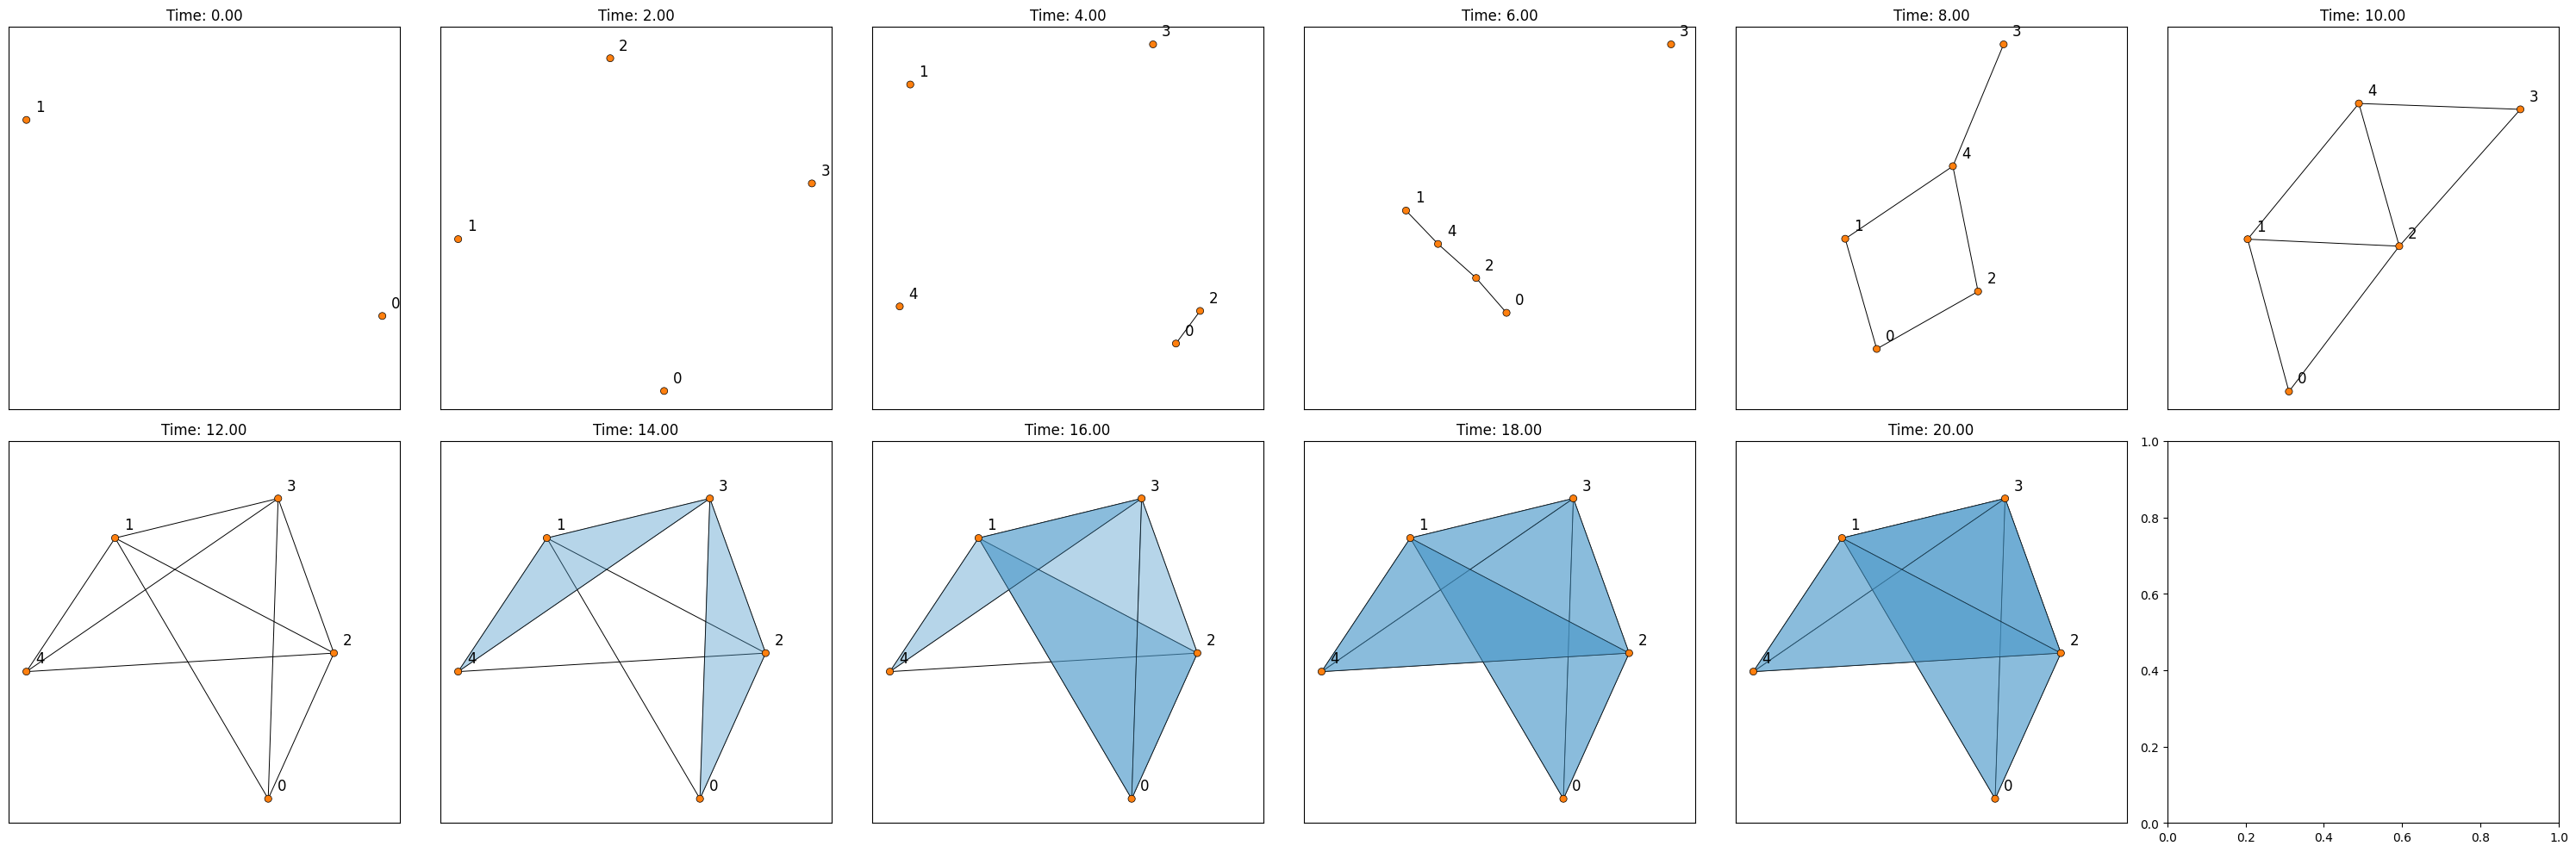

In [6]:
from venv import create


def create_cycle(n, overlap = 0, start_n=0, overlap_start = 0):
    simplices = []
    for v_i in range(n):
        if v_i < overlap:
            simplices.append(([v_i+overlap_start], 0))
            if v_i + 1 == overlap:
                simplices.append(([v_i+overlap_start, start_n], 1))
            else:
                simplices.append(([v_i+overlap_start, v_i+overlap_start+1], 1))
        elif v_i < n-1:
            simplices.append(([v_i+start_n-overlap], 0))
            simplices.append(([v_i+start_n-overlap, v_i+1+start_n-overlap], 1))
        else:
            simplices.append(([v_i+start_n-overlap], 0))
            # If you started with overlap, go to overlap_start. Otherwise go to start_n.
            simplices.append(([v_i+start_n-overlap, start_n*(overlap==0)+overlap_start*(overlap > 0)], 1))
    return simplices
    
def create_path(n, end_path = -1):
    if end_path < 0:
        end_path += n+1
    simplices = [([0], 0), ([end_path], 1)]
    for i in range(1,n):
        if i < end_path:
            simplices.append(([i], len(simplices)))
        else:
            simplices.append(([i+1], len(simplices)))
    for i in range(end_path-1):
        simplices.append(([i, i+1], len(simplices)))
    for i in range(end_path, n):
        simplices.append(([i, i+1], len(simplices)))
    simplices.append(([end_path-1, end_path], len(simplices)))
    return simplices
    

# Drawn
simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([2,3], 7), ([0,2], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([2,3], 5), ([4], 6), ([2,4], 7), ([3,4], 8), ([2,3,4], 9), ([0,3], 10), ([1,3], 11), ([0,2], 12), ([0,1,3], 13)]#, ([0,2,3], 10)]

# Swapped 7 and 8
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 5), ([1,3], 6), ([0,2], 7), ([2,3], 8), ([0,1,3], 9)]#, ([0,2,3], 10)]

# "Flipped"
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped d and e
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([1,2], 5), ([0,2], 6), ([2,3], 7), ([1,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# "Flipped", swapped b and c
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([0,1], 4), ([0,2], 5), ([1,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# swapped 2 and 3
# simplices = [([0], 0), ([1], 1),  ([3], 2), ([2], 3),([0,1], 4), ([1,2], 5), ([0,2], 6), ([1,3], 7), ([2,3], 8), ([0,1,2], 9)]#, ([0,2,3], 10)]

# Non equidistant time intervals
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([1,0], 4), ([0,3], 8), ([1,3], 10), ([2,3], 10.1), ([0,2], 12), ([0,1,3], 12.5)]

# Ren paper
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,2], 1), ([0,3], 1), ([2,3], 1), ([0,1], 2), ([0,2,3], 3)]

# Drawn new
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 1), ([0,1], 2), ([1,2], 2), ([2,3], 2), ([0,2], 3), ([0,3], 3), ([4], 4), ([2,4], 5), ([3,4], 5), ([0,1,2], 6), ([2,3,4], 7), ([0,2,3], 8)]

# Test easy
# simplices = [([0], 0), ([1], 0), ([2], 0), ([0,1], 0), ([0,2], 0), ([1,2], 0),
#              ([3], 1), ([2,3], 1), ([1,3], 1), ([0,1,2], 1), ([1,2,3], 1)]

# Test hard
# simplices = [([0], 0), ([1], 0), ([2], 0), ([3], 0), ([0,1], 0), ([0,2], 0), ([1,3], 0), ([2,3], 0),
#               ([1,2], 1),  ([0,1,2], 1), ([1,2,3], 1)]

# Example PowerPoint
# simplices = [([0],0), ([1], 0), ([2], 1), ([3], 1), ([4], 1), ([0,2], 1), ([2,3], 1), ([2,4], 1), ([3,4], 1), ([1,4], 1)]

# Dimension 2 feature
# simplices = [([0],0), ([1], 1), ([0,1], 1), ([2], 2), ([0,2], 2), ([1,2], 2), ([3], 3), ([0,3], 3), ([1,3], 3), ([2,3], 3), ([0,2,3], 4), ([1,2,3], 5), ([0,1,2], 6), ([0,1,3], 7)]

# 2 dimension 2 features
# simplices = [([0], 0), ([1], 1), ([2], 2), ([3], 3), ([4], 4), ([0,2], 5), 
#              ([2,4], 6), ([1,4], 7), ([0,1], 8), ([3,4], 9), ([2,3], 10), ([1,2], 11), 
#              ([1,3], 12), ([0,3], 13), ([0,2,3], 14), ([1,3,4], 15), ([0,1,3], 16), ([0,1,2], 17),
#              ([2,3,4], 18), ([1,2,4], 19), ([1,2,3], 20), ([0,1,2,3], 21)]

# Fewer timesteps
simplices = [([0], 0), ([1], 0), ([2], 2), ([3], 2), ([4], 4), ([0,2], 4), 
             ([2,4], 6), ([1,4], 6), ([0,1], 8), ([3,4], 8), ([2,3], 10), ([1,2], 10), 
             ([1,3], 12), ([0,3], 12), ([0,2,3], 14), ([1,3,4], 14), ([0,1,3], 16), ([0,1,2], 16),
             ([2,3,4], 18), ([1,2,4], 18), ([1,2,3], 20), ([0,1,2,3], 20)]

# NOT 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 2), ([0,2], 4), ([0,1], 4),  ([1,2], 3)]

# 2 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([1,2], 3), ([0,1], 2), ([0,2], 3)]

# 3 eigenvalues
# simplices = [([0], 0), ([1], 1), ([2], 1), ([3], 1), ([0,3], 2), ([0,1], 2), ([1,2], 2), ([2,3], 2)]

# simplices = [([0], 0), ([3], 1), ([6], 1), ([1], 2), ([0,1], 2), ([4], 2), ([3,4], 2), ([7], 2), ([6,7], 2.5), ([2], 3), ([5], 3), ([8], 3), ([1,2], 3), ([2,3], 4), ([4,5], 4), ([5,6], 4), ([7,8], 4), ([0,8], 4)]

# Path
# simplices = create_path(8, end_path=-1)

# Cycles
# simplices = create_cycle(3)
x = 4
y = 4
z = 4
x4 = 5
overlap = 3
# Three cycles added in order x->y->z, with x and z not connected.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap, overlap_start=x-overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap, overlap_start=x+y-2*overlap)
# Three cycles added with all of them connecting on overlap vertices.
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)
# simplices = create_cycle(x) + create_cycle(y, start_n=x, overlap=overlap) + create_cycle(z, start_n=x+y-overlap, overlap=overlap)+ create_cycle(x4, start_n=x+y+z-2*overlap, overlap=overlap)
# simplices.append(([7], 0))
# simplices.append(([6,7], 1))
# simplices = create_cycle(7)
# simplices.append(([10], 2))
# simplices.append(([0,2], 2))
# simplices.append(([0,1,2], 2))
# simplices.append(([0,3], 3))
# simplices.append(([0,2,3], 3))
# print(simplices)

f = d.Filtration()
for vertices, time in simplices:
    f.append(d.Simplex(vertices, time))

draw_filtration(f)

# Drawing graph
# G = nx.Graph()
# f.sort()
# for s in f:
#     if s.dimension() == 0:
#         G.add_node(s[0])
#     elif s.dimension() == 1:
#         G.add_edge(s[0], s[1])
# nx.draw_planar(G, with_labels=True)

In [7]:
def Laplacian_fun(B22_st, B22_stm1, B22_sm1t, B22_sm1tm1, eye):
    # return B22_stm1@B22_sm1t@(eye-B22_st)@B22_sm1t
    # return B22_sm1t@(eye-B22_st)@B22_sm1t@B22_stm1
    # return B22_sm1t@B22_stm1@(eye-B22_st)@B22_stm1
    # return B22_stm1@(eye-B22_st)@B22_stm1@B22_sm1t
    # return B22_sm1tm1-B22_sm1t-B22_stm1+B22_st

    
    # return B22_stm1@B22_sm1t+B22_sm1t@B22_stm1-2*B22_st
    # return eye-B22_st

    # return B22_stm1@(eye-B22_st)@(eye - B22_sm1tm1 + B22_sm1t)

    # Best
    return B22_sm1t@B22_stm1-B22_st
    # return B22_stm1@B22_sm1t-B22_st

    # Normal
    # return -1*(B22_sm1tm1 - B22_sm1t - B22_stm1 + B22_st)

    # return B22_sm1t - B22_st
    
cross_Lap = calc_cross(f, 0, 2, 8, verb=True, Laplacian_fun = Laplacian_fun)
print(f"Cross_Lap\n{torch.round(cross_Lap, decimals=5)}")
evals, evecs = torch.linalg.eig(cross_Lap)
for i, eval in enumerate(evals.real):
    # if np.abs(eval) > 1e-8:
    print("eval:", eval)
    evec = evecs[:,i].real
    print("normalized evec", torch.round(evec, decimals=5))
    print("denormalized evec",torch.round(evec/torch.min(torch.abs(evec[torch.abs(evec) > 1e-8])),decimals=5))
    print()

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.
Bqplus1:
tensor([[-1.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.],
        [ 0., -1.,  0.,  1.,  0., -1.,  0.,  0., -1.],
        [ 1.,  0., -1.,  0.,  0.,  1., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.],
        [ 0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]], device='cuda:0')
n_q_t:[5, 5, 0, 0, 0], n_q_s: [4, 0, 0, 0, 0]
B12_st:
tensor([[-1.,  0.,  0., -1.,  0.],
        [ 0., -1.,  0.,  1.,  0.],
        [ 1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.]], device='cuda:0')
B22_st:
tensor([[0., 1., 1., 0., 1.]], device='cuda:0')
B22_stm1:
tensor([[0., 1., 1.]], device='cuda:0')
B22_sm1t:
tensor([[ 1.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.],
        [ 0.,  1.,  1.,  0.,  1.]], device='cuda:0')
B22_sm1tm1:
tensor([[ 1.,  0., -1.],
        [ 0.,  0.,  0.],
        [ 0.,  1.,  1.]], device='cuda:0')
A_matrix:
tensor([[-1.,  0.,  0., -1.,  0.],
        [ 0., -1.,  0.,  1.,  0.],
        [ 1.,  0., -1.,  0.,

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

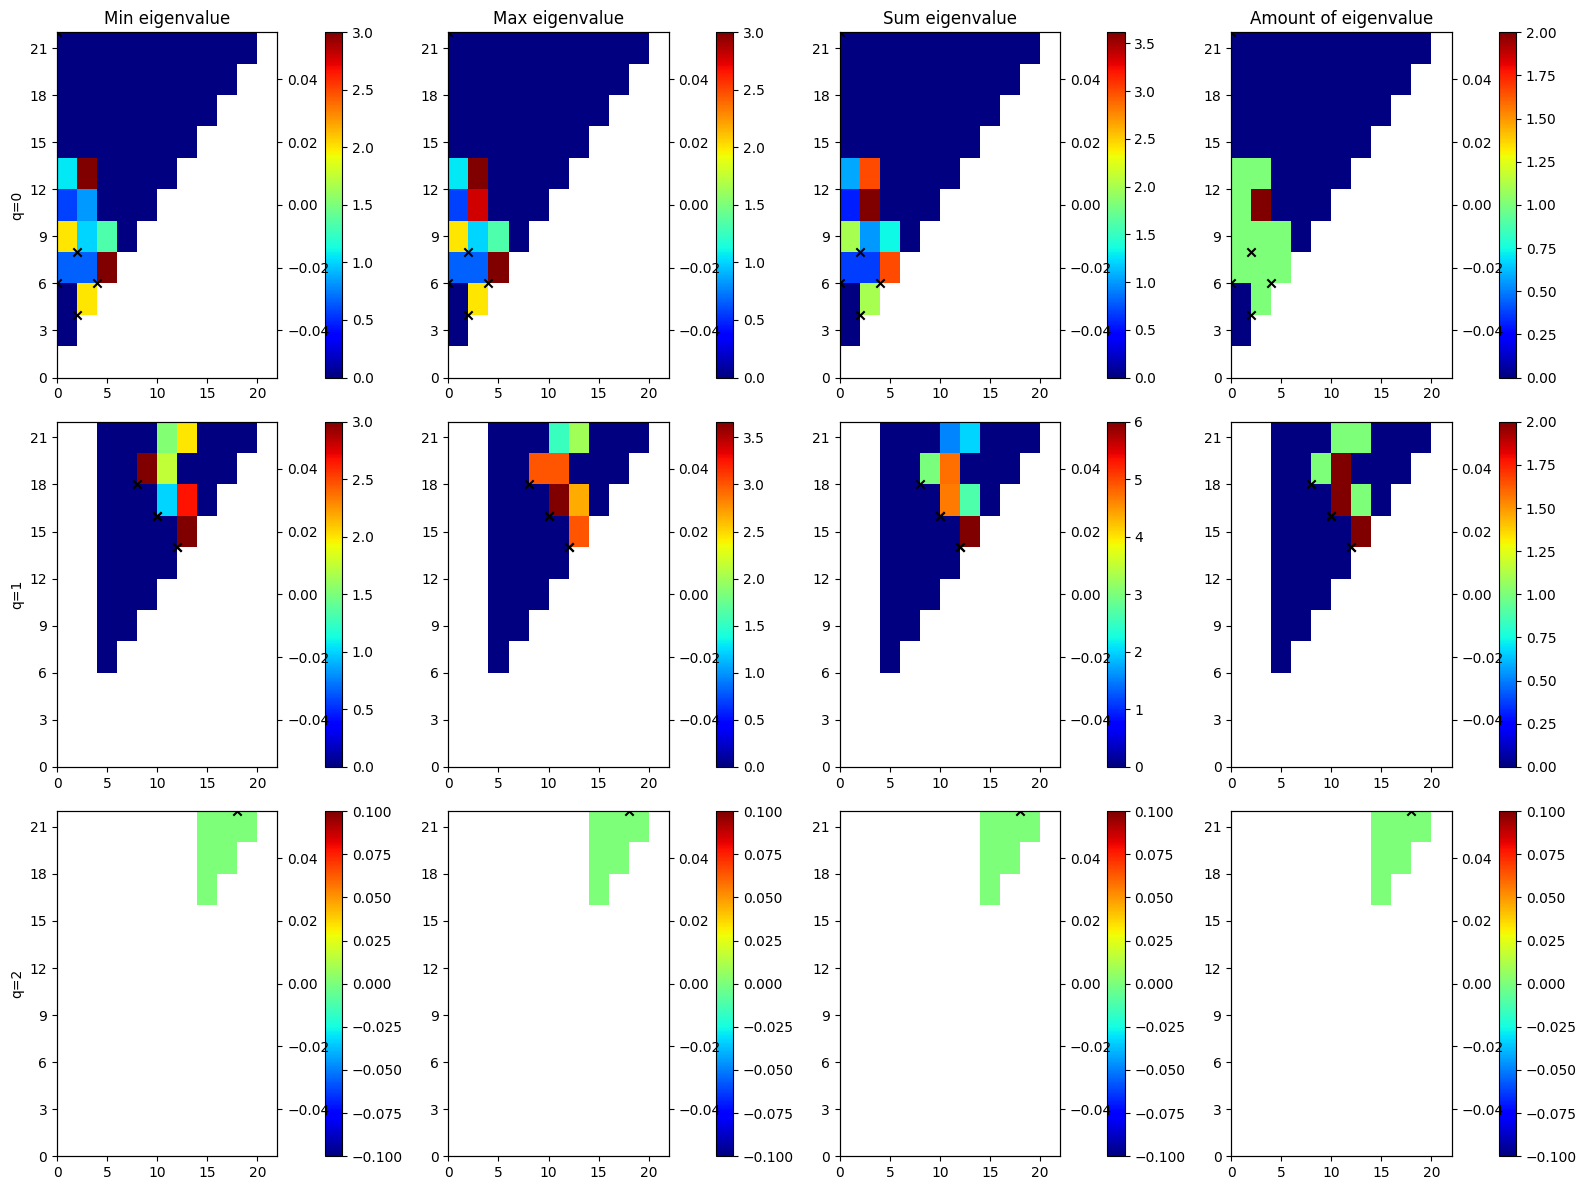

In [8]:
eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, max_dim =2, plot_types=["Min", "Max", "Sum", "Amount of"], Laplacian_fun= Laplacian_fun, method="less_memory", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, integer_time_steps=True, device="cpu")

Computing boundary matrices:   0%|          | 0/22 [00:00<?, ?it/s]

Computing boundary matrices done.
Calculating projection matrices...


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Calculating Laplacians and eigenvalues...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

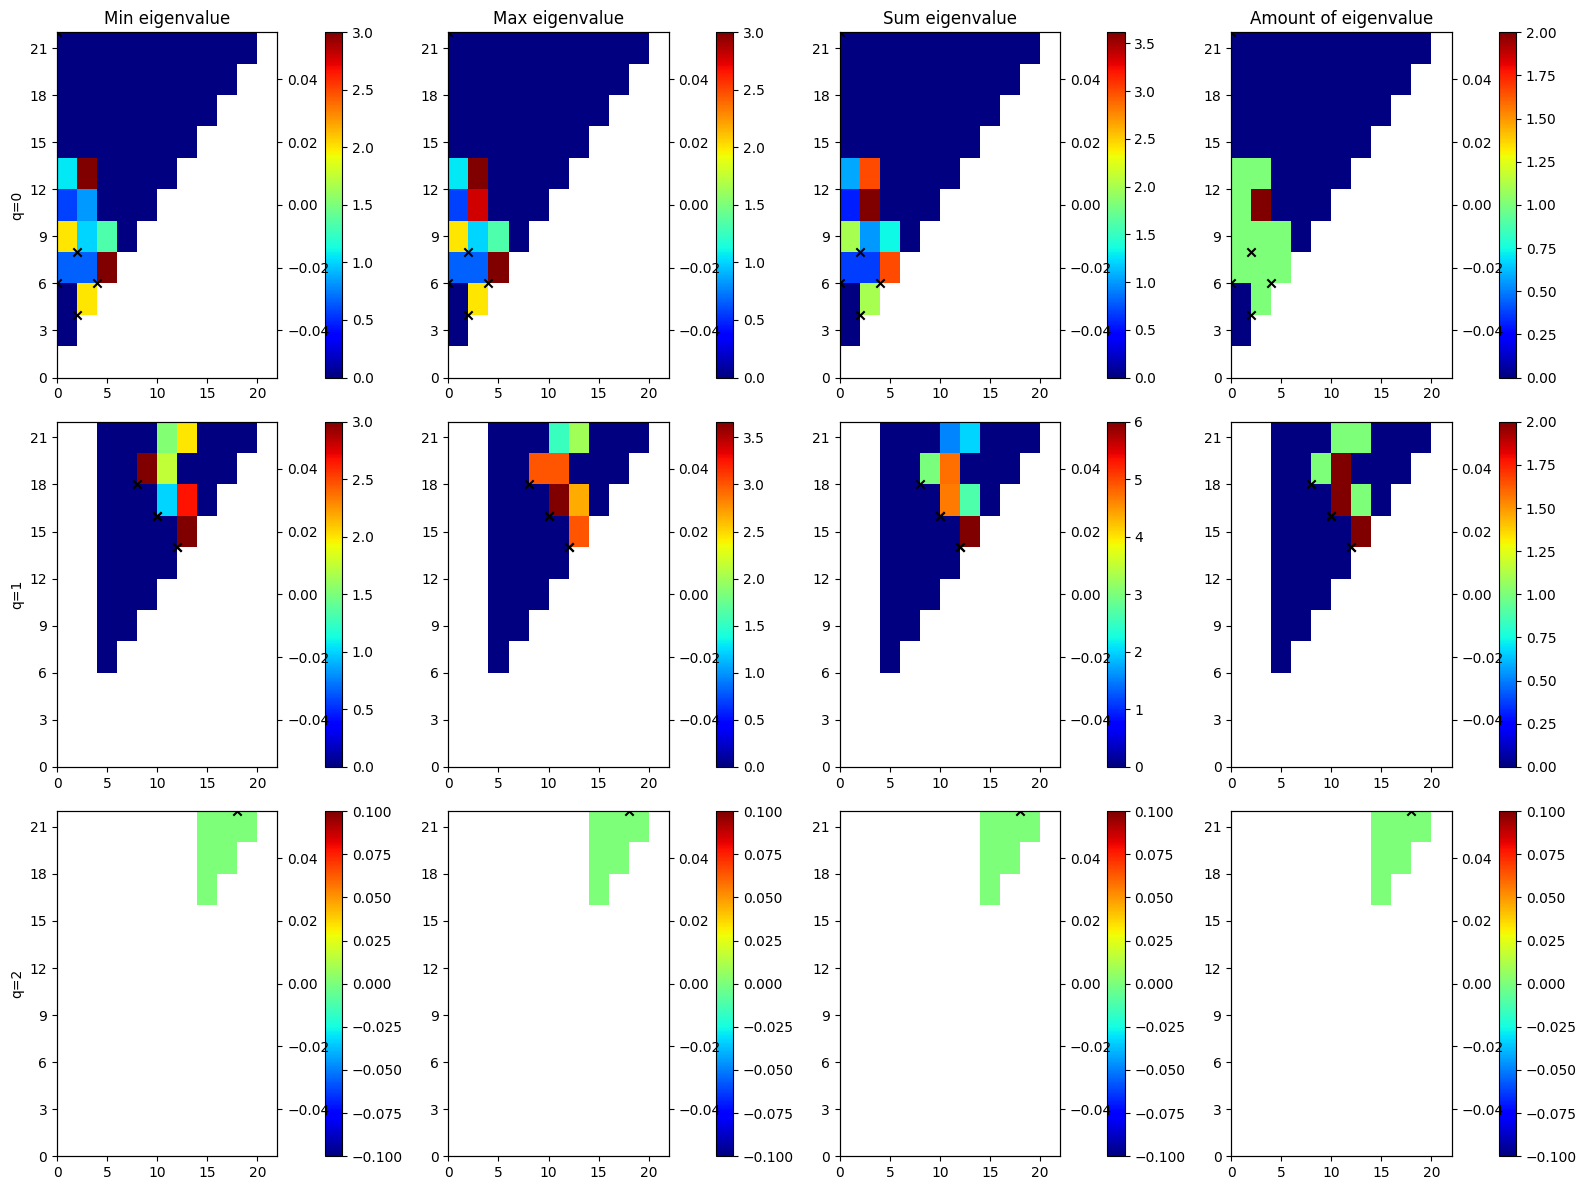

In [9]:
eigenvalues, relevant_times, fig, ax = plot_Laplacian_new_eigenvalues(f, lambda x: 1, max_dim =2, plot_types=["Min", "Max", "Sum", "Amount of"], Laplacian_fun= Laplacian_fun, method="greville", plot_args_diag={"c": "black", "alpha": 1, "marker": "x"}, plot_type_to_fun={"Amount of": len}, integer_time_steps=True, device="cpu")